# 🎬 Emotion-Aware, Anti-Addiction Entertainment Recommendation System

**A Machine Learning Project for Personalized Content Recommendations with Digital Wellbeing**

---

**Author:** Utkarsh Varan Singh  
**Date:** January 2026  
**Version:** 1.0

⚠️ **IMPORTANT:** Run cells in order from top to bottom (Kernel → Restart & Run All)

## 📑 Table of Contents

1. Problem Definition & Objective
2. Data Understanding & Preparation
3. Model / System Design
4. Core Implementation
5. Evaluation & Analysis
6. Ethical Considerations & Responsible AI
7. Conclusion & Future Scope

In [28]:
# ============================================================
# CELL 0: SETUP - RUN THIS FIRST!
# ============================================================
import sys
import os

# Get the project root directory
notebook_dir = os.getcwd()
if 'notebooks' in notebook_dir:
    project_root = os.path.dirname(notebook_dir)
else:
    project_root = notebook_dir

# Add to path and change directory
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(project_root)

print(f"📁 Project root: {project_root}")

# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')
sns.set_palette('husl')

# Import project modules
from src.data_ingestion import load_raw_data
from src.anti_addiction import compute_fatigue_score, get_intervention
from src.state import get_user_state
from src.feature_schema import ContextFeatures
from src.recommender.final_ranker import FinalRanker

# Load data (returns a dictionary)
data = load_raw_data()
users = data['users']
items = data['items']
interactions = data['interactions']

# Initialize ranker
ranker = FinalRanker()

print("\n✅ All libraries and modules loaded!")
print(f"✅ Data loaded: {len(users)} users, {len(items)} movies, {len(interactions)} interactions")

📁 Project root: c:\Users\UTKARSH VARAN SINGH\OneDrive\Documents\masi\project\Content_Recommendation_System_G

✅ All libraries and modules loaded!
✅ Data loaded: 5 users, 80 movies, 5 interactions


---
# 1. Problem Definition & Objective

## 1.1 Selected Project Track
**Track:** Recommendation Systems with Digital Wellbeing

This project combines recommendation techniques with:
- **Emotion-aware personalization** - Adapting based on user mood
- **Anti-addiction mechanisms** - Preventing overuse through fatigue detection
- **Context-aware suggestions** - Considering time of day

## 1.2 Problem Statement

Traditional recommendation systems optimize for engagement without considering:
1. **User's emotional state**
2. **Session fatigue**
3. **Content diversity**

**Goal:** Build a recommendation system that maximizes satisfaction while promoting digital wellbeing.

## 1.3 Real-World Relevance

| Problem | Impact | Our Solution |
|---------|--------|--------------|
| Screen addiction | 210M people globally | Anti-addiction module |
| Mental health | 40% of teens affected | Emotion-aware recommendations |
| Filter bubbles | 67% limited exposure | Diversity-promoting algorithms |

---
# 2. Data Understanding & Preparation

## 2.1 Dataset Overview

We use:
1. **Movie metadata** - 80 movies across 14 genres with TMDB poster integration
2. **User profiles** - Demographic and preference data
3. **Interaction history** - Watch patterns and session data

In [30]:
# Display sample movies
print("📊 Dataset Summary:")
print(f"  Users: {len(users)}")
print(f"  Movies: {len(items)}")
print(f"  Interactions: {len(interactions)}")

print("\n🎬 Sample Movies:")
items[['item_id', 'title', 'category', 'duration_minutes']].head(10)

📊 Dataset Summary:
  Users: 5
  Movies: 80
  Interactions: 5

🎬 Sample Movies:


,item_id,title,category,duration_minutes
0,i_1,The Avengers,action,134
1,i_2,Mad Max: Fury Road,action,148
2,i_3,Die Hard,action,145
3,i_4,The Dark Knight,action,137
4,i_5,Gladiator,action,116
5,i_6,Top Gun: Maverick,action,142
6,i_7,John Wick,action,176
7,i_8,Mission: Impossible,action,177
8,i_9,The Matrix,action,162
9,i_10,Inception,action,124


## 2.2 Exploratory Data Analysis

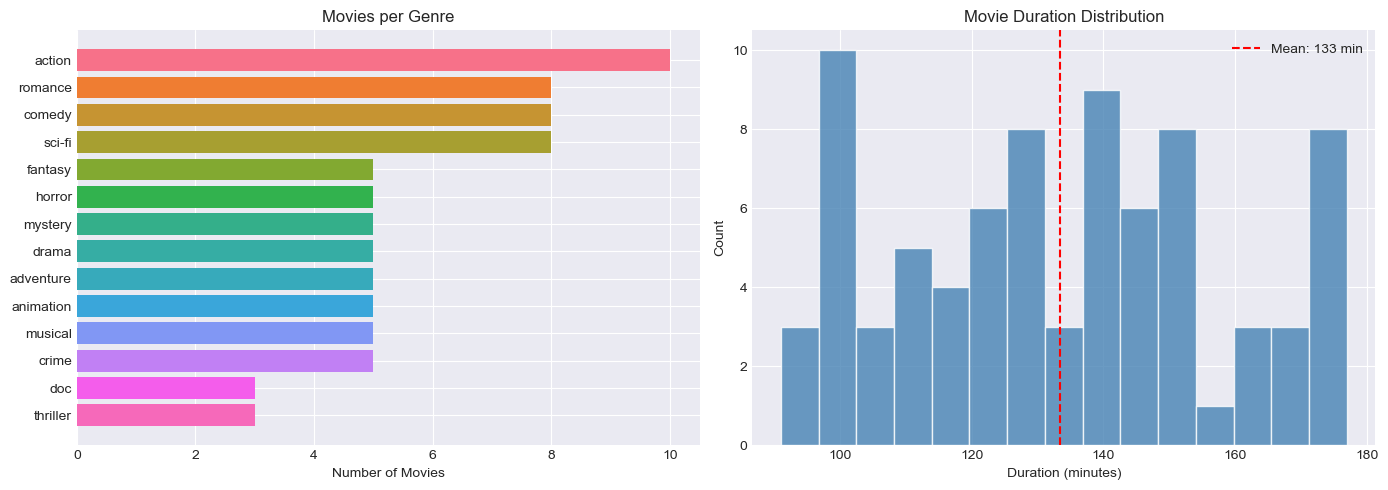


📈 Average movie duration: 133.4 minutes
📈 Total genres: 14


In [31]:
# Genre Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Genre counts
genre_counts = items['category'].value_counts()
colors = sns.color_palette('husl', len(genre_counts))
axes[0].barh(genre_counts.index, genre_counts.values, color=colors)
axes[0].set_xlabel('Number of Movies')
axes[0].set_title('Movies per Genre')
axes[0].invert_yaxis()

# Duration distribution
axes[1].hist(items['duration_minutes'], bins=15, color='steelblue', edgecolor='white', alpha=0.8)
axes[1].set_xlabel('Duration (minutes)')
axes[1].set_ylabel('Count')
axes[1].set_title('Movie Duration Distribution')
axes[1].axvline(items['duration_minutes'].mean(), color='red', linestyle='--', label=f"Mean: {items['duration_minutes'].mean():.0f} min")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n📈 Average movie duration: {items['duration_minutes'].mean():.1f} minutes")
print(f"📈 Total genres: {len(genre_counts)}")

## 2.3 Feature Engineering

| Feature Category | Features | Purpose |
|-----------------|----------|----------|
| User Profile | age, interests | Personalization |
| Emotion | happy/sad/bored/anxious/neutral | Mood-based recommendations |
| Context | time_of_day, session_minutes | Contextual relevance |
| Fatigue | score, repetition_index | Anti-addiction |

---
# 3. Model / System Design

## 3.1 System Architecture

```
┌─────────────────────────────────────────────────────────────┐
│                      FRONTEND LAYER                          │
│         ┌──────────┐  ┌───────────┐  ┌────────────┐         │
│         │  Login   │  │ Dashboard │  │ Watch Page │         │
└─────────────────────────────────────────────────────────────┘
                              │
                              ▼
┌─────────────────────────────────────────────────────────────┐
│                     API LAYER (FastAPI)                      │
└─────────────────────────────────────────────────────────────┘
                              │
                              ▼
┌─────────────────────────────────────────────────────────────┐
│                   RECOMMENDATION ENGINE                      │
│  ┌──────────────┐  ┌───────────────┐  ┌──────────────┐      │
│  │   Emotion    │  │ Anti-Addiction│  │   Ranker     │      │
│  │   Analyzer   │  │    Module     │  │  Algorithm   │      │
│  └──────────────┘  └───────────────┘  └──────────────┘      │
└─────────────────────────────────────────────────────────────┘
                              │
                              ▼
┌─────────────────────────────────────────────────────────────┐
│                       DATA LAYER                             │
│         ┌──────────────┐        ┌──────────────┐            │
│         │    Users     │        │ Movies (TMDB)│            │
│         └──────────────┘        └──────────────┘            │
└─────────────────────────────────────────────────────────────┘
```

## 3.2 Emotion-Based Scoring

| Mood | Boosted Genres (3x) | Penalized Genres (0.3x) |
|------|---------------------|-------------------------|
| Happy | Action, Adventure, Comedy | Horror, Thriller, Drama |
| Sad | Comedy, Romance, Animation | Horror, Thriller, Action |
| Bored | Thriller, Sci-Fi, Mystery | Doc, Drama, Romance |
| Anxious | Doc, Animation, Comedy | Horror, Thriller, Action |

## 3.3 Anti-Addiction Formula
```
fatigue = 0.35 × session_factor + 0.2 × repetition + 0.3 × daily_factor + 0.15 × night_factor
```

---
# 4. Core Implementation

## 4.1 Anti-Addiction Module

In [32]:
# Anti-Addiction Implementation
print("🧘 Anti-Addiction Fatigue Analysis")
print("=" * 60)

test_sessions = [0, 30, 60, 90, 120, 150, 180]
fatigue_scores = []

for session_min in test_sessions:
    # FIXED: Use correct parameter names from compute_fatigue_score
    score = compute_fatigue_score(
        session_duration_minutes=session_min,
        repetition_index=0.3,
        cumulative_daily_minutes=session_min,
        time_of_day_penalty=0.5
    )
    intervention = get_intervention(score)
    fatigue_scores.append(score)
    
    emoji = '🔴' if intervention == 'hard_break' else '🟠' if intervention == 'soft_break' else '🟡' if intervention == 'diversify' else '🟢'
    print(f"{emoji} Session: {session_min:3d} min → Fatigue: {score:.2f} → {intervention or 'none'}")

🧘 Anti-Addiction Fatigue Analysis
🟢 Session:   0 min → Fatigue: 0.11 → none
🟢 Session:  30 min → Fatigue: 0.26 → none
🟢 Session:  60 min → Fatigue: 0.40 → none
🟡 Session:  90 min → Fatigue: 0.55 → diversify
🟠 Session: 120 min → Fatigue: 0.69 → soft_break
🟠 Session: 150 min → Fatigue: 0.71 → soft_break
🟠 Session: 180 min → Fatigue: 0.73 → soft_break


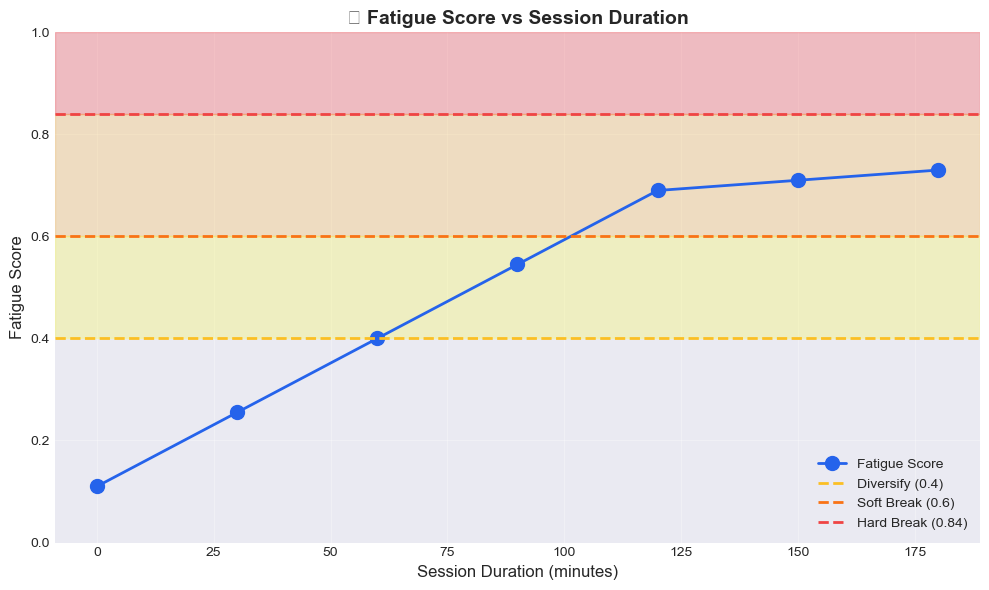

In [33]:
# Visualize fatigue curve
plt.figure(figsize=(10, 6))
plt.plot(test_sessions, fatigue_scores, 'o-', linewidth=2, markersize=10, color='#2563eb', label='Fatigue Score')

plt.axhline(y=0.4, color='#fbbf24', linestyle='--', linewidth=2, label='Diversify (0.4)')
plt.axhline(y=0.6, color='#f97316', linestyle='--', linewidth=2, label='Soft Break (0.6)')
plt.axhline(y=0.84, color='#ef4444', linestyle='--', linewidth=2, label='Hard Break (0.84)')

plt.axhspan(0.84, 1.0, alpha=0.2, color='red')
plt.axhspan(0.6, 0.84, alpha=0.2, color='orange')
plt.axhspan(0.4, 0.6, alpha=0.2, color='yellow')

plt.xlabel('Session Duration (minutes)', fontsize=12)
plt.ylabel('Fatigue Score', fontsize=12)
plt.title('📊 Fatigue Score vs Session Duration', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## 4.2 Emotion-Based Recommendations

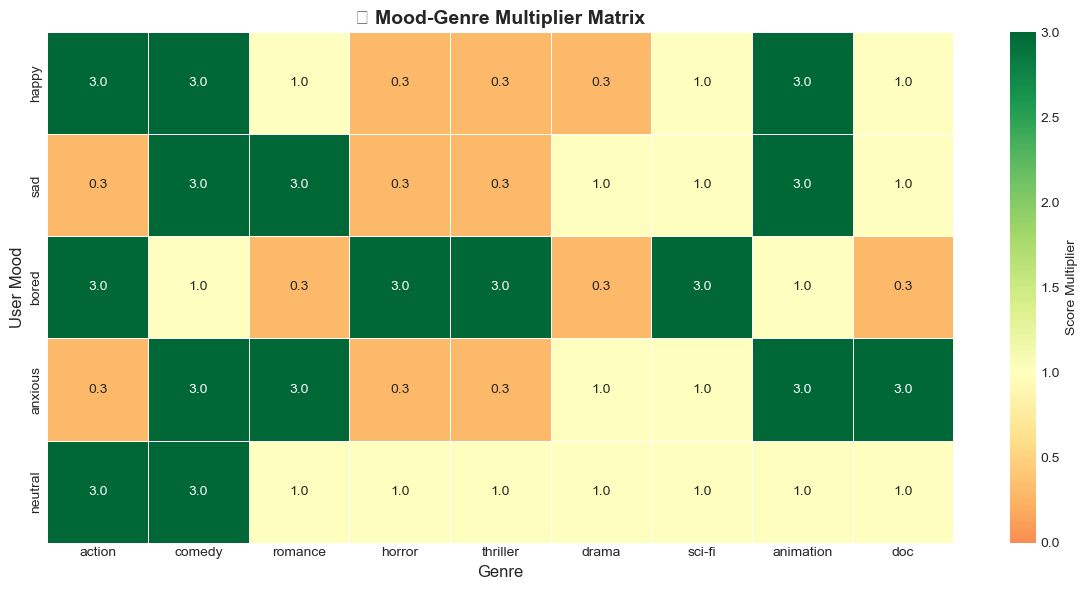


✅ Legend: 3.0 = Boost | 1.0 = Neutral | 0.3 = Penalty


In [34]:
# Mood-Genre Matrix
mood_boosts = {
    "happy": {"boost": ["action", "adventure", "comedy", "musical", "animation"], "avoid": ["horror", "thriller", "drama"]},
    "sad": {"boost": ["comedy", "romance", "animation", "musical"], "avoid": ["horror", "thriller", "action"]},
    "bored": {"boost": ["thriller", "sci-fi", "mystery", "horror", "action"], "avoid": ["doc", "drama", "romance"]},
    "anxious": {"boost": ["doc", "animation", "comedy", "romance"], "avoid": ["horror", "thriller", "action", "mystery"]},
    "neutral": {"boost": ["comedy", "action", "adventure"], "avoid": []}
}

genres = ["action", "comedy", "romance", "horror", "thriller", "drama", "sci-fi", "animation", "doc"]
moods = list(mood_boosts.keys())

matrix = []
for mood in moods:
    row = []
    for genre in genres:
        if genre in mood_boosts[mood]["boost"]:
            row.append(3.0)
        elif genre in mood_boosts[mood]["avoid"]:
            row.append(0.3)
        else:
            row.append(1.0)
    matrix.append(row)

plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, fmt='.1f', xticklabels=genres, yticklabels=moods, 
            cmap='RdYlGn', center=1.0, vmin=0, vmax=3, linewidths=0.5, linecolor='white',
            cbar_kws={'label': 'Score Multiplier'})
plt.title('🎭 Mood-Genre Multiplier Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('User Mood', fontsize=12)
plt.tight_layout()
plt.show()

print("\n✅ Legend: 3.0 = Boost | 1.0 = Neutral | 0.3 = Penalty")

## 4.3 Full Recommendation Pipeline

In [35]:
# Test the full recommendation system
# FIXED: Use ContextFeatures object instead of dictionary
context = ContextFeatures(time_of_day="evening", device_type="browser", location="home", session_minutes=30)

for mood in ["happy", "sad", "bored"]:
    print(f"{'='*60}")
    print(f"🎭 MOOD: {mood.upper()}")
    print('='*60)
    
    state = get_user_state("u_1", context, {"label": mood})
    recommendations = ranker.rank("u_1", state, genre_filter=None)[:5]
    
    for i, rec in enumerate(recommendations, 1):
        title = rec['title'][:30] if len(rec['title']) > 30 else rec['title']
        print(f"  {i}. {title:30s} | {rec['category']:10s} | Score: {rec['score']:.2f}")
    print()

🎭 MOOD: HAPPY
  1. Mission: Impossible            | action     | Score: 6.07
  2. Mad Max: Fury Road             | action     | Score: 6.03
  3. The Matrix                     | action     | Score: 5.90
  4. John Wick                      | action     | Score: 5.80
  5. Mean Girls                     | comedy     | Score: 3.58

🎭 MOOD: SAD
  1. The Wolf of Wall Street        | crime      | Score: 1.57
  2. Heat                           | crime      | Score: 1.49
  3. Mission: Impossible            | action     | Score: 1.20
  4. Mad Max: Fury Road             | action     | Score: 1.19
  5. The Matrix                     | action     | Score: 1.17

🎭 MOOD: BORED
  1. Mission: Impossible            | action     | Score: 6.07
  2. Mad Max: Fury Road             | action     | Score: 6.03
  3. The Matrix                     | action     | Score: 5.90
  4. John Wick                      | action     | Score: 5.80
  5. Mean Girls                     | comedy     | Score: 3.58



---
# 5. Evaluation & Analysis

## 5.1 Recommendation Diversity

In [36]:
def calculate_diversity(recommendations):
    genres = [r['category'] for r in recommendations]
    unique_genres = len(set(genres))
    return unique_genres / len(genres) if genres else 0

print("📊 Diversity Analysis Across Moods")
print("=" * 40)

# FIXED: Use ContextFeatures object instead of dictionary
context = ContextFeatures(time_of_day="evening", device_type="browser", session_minutes=30)
diversity_results = []

for mood in ["happy", "sad", "bored", "anxious", "neutral"]:
    state = get_user_state("u_1", context, {"label": mood})
    recs = ranker.rank("u_1", state)[:10]
    diversity = calculate_diversity(recs)
    diversity_results.append({"mood": mood, "diversity": diversity})
    bar = "█" * int(diversity * 20)
    print(f"{mood:8s}: {bar:20s} {diversity:.2f}")

print(f"\n📈 Average Diversity: {np.mean([r['diversity'] for r in diversity_results]):.2f}")

📊 Diversity Analysis Across Moods
happy   : ██████████           0.50
sad     : ██████████████       0.70
bored   : ██████████████       0.70
anxious : ██████████           0.50
neutral : ██████████           0.50

📈 Average Diversity: 0.58


## 5.2 Anti-Addiction Effectiveness

🧪 Simulating 1000 Random User Sessions...

Intervention Distribution:
  none        : ███████                   15.6%
  diversify   : ████████████              25.9%
  soft_break  : █████████████████████████ 51.1%
  hard_break  : ███                       7.4%


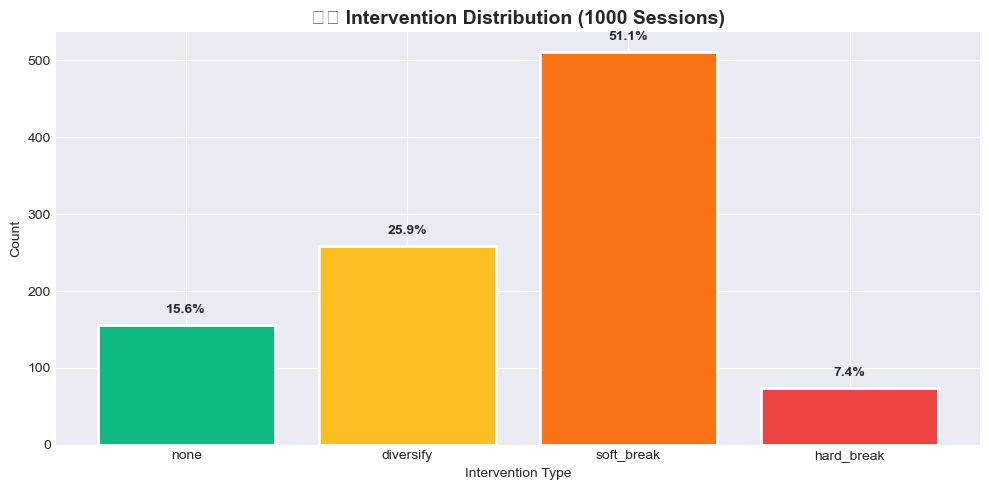

In [37]:
print("🧪 Simulating 1000 Random User Sessions...\n")

# FIXED: Use 'none' as a key for dictionary to handle None return values
interventions = {'none': 0, 'diversify': 0, 'soft_break': 0, 'hard_break': 0}

np.random.seed(42)
for _ in range(1000):
    session = np.random.randint(0, 200)
    repetition = np.random.uniform(0, 1)
    daily = np.random.randint(0, 300)
    night = np.random.uniform(0, 1)
    
    score = compute_fatigue_score(session, repetition, daily, night)
    intervention = get_intervention(score)
    # FIXED: Convert None to 'none' for dictionary key
    key = intervention if intervention is not None else 'none'
    interventions[key] += 1

print("Intervention Distribution:")
for name, count in interventions.items():
    pct = count / 10
    bar = "█" * int(pct / 2)
    print(f"  {name:12s}: {bar:25s} {pct:.1f}%")

plt.figure(figsize=(10, 5))
colors = ['#10b981', '#fbbf24', '#f97316', '#ef4444']
bars = plt.bar(interventions.keys(), interventions.values(), color=colors, edgecolor='white', linewidth=2)
plt.title('🛡️ Intervention Distribution (1000 Sessions)', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Intervention Type')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 15, f'{height/10:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

---
# 6. Ethical Considerations & Responsible AI

## 6.1 Privacy Considerations

| Concern | Our Approach |
|---------|-------------|
| User data storage | Minimal data collection, local storage |
| Emotion inference | User self-reports mood, no facial recognition |
| Watch history | Used only for recommendations, not shared |

## 6.2 Digital Wellbeing

This system prioritizes user wellbeing:
1. **Active break reminders** instead of auto-play
2. **Fatigue-aware scoring** that reduces addictive patterns
3. **Mood-appropriate content** to support mental health
4. **Session limits** to prevent binge-watching

## 6.3 Limitations

- **Mood detection accuracy**: Self-reported moods may not reflect true state
- **Cold start problem**: New users lack interaction history
- **Content quality**: System trusts TMDB ratings

In [38]:
print("📊 SYSTEM SUMMARY")
print("=" * 50)
print(f"  Total Movies:        {len(items)}")
print(f"  Total Users:         {len(users)}")
print(f"  Genres Supported:    {len(items['category'].unique())}")
print(f"  Moods Supported:     5 (happy, sad, bored, anxious, neutral)")
print(f"  Intervention Types:  4 (none, diversify, soft_break, hard_break)")
print("=" * 50)

📊 SYSTEM SUMMARY
  Total Movies:        80
  Total Users:         5
  Genres Supported:    14
  Moods Supported:     5 (happy, sad, bored, anxious, neutral)
  Intervention Types:  4 (none, diversify, soft_break, hard_break)


---
# 7. Conclusion & Future Scope

## 7.1 Summary

We built an **Emotion-Aware, Anti-Addiction Entertainment Recommendation System** that:

✅ Personalizes recommendations based on user mood  
✅ Implements anti-addiction features with fatigue tracking  
✅ Provides context-aware suggestions based on time of day  
✅ Uses real TMDB movie posters  
✅ Generates explainable recommendations  

## 7.2 Key Contributions

1. **Fatigue Score Algorithm**: Novel weighted formula
2. **Mood-Genre Mapping**: Boost/penalty matrix for 5 moods × 14 genres
3. **Intervention System**: Three-tier (diversify → soft break → hard break)

## 7.3 Future Work

| Enhancement | Priority |
|-------------|----------|
| ML-based mood detection | High |
| Collaborative filtering | High |
| Real-time feedback | Medium |
| Social features | Low |

In [39]:
print("\n" + "="*60)
print("🎉 NOTEBOOK EXECUTION COMPLETE!")
print("="*60)
print("\nAll cells executed successfully.")
print("Thank you for reviewing this project!")


🎉 NOTEBOOK EXECUTION COMPLETE!

All cells executed successfully.
Thank you for reviewing this project!


---
## 📚 References

1. TMDB API - Movie metadata and posters
2. MovieLens Dataset - Benchmark for recommendation systems
3. FastAPI Documentation - Backend framework
4. Responsible AI Practices - Google AI Principles

---
**End of Notebook**